In [101]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [102]:
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)

print(df.shape)
df.head()

(3925, 15)


,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend,btc_log_return,btc_rsi,eth_log_return,sp500_log_return,gold_log_return,dxy_log_return
2014-09-17,457.334015,160989.0,84.699997,NaN,NaN,1234.400024,0.09,2001.569946,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,160989.0,84.320000,NaN,NaN,1225.699951,0.09,2011.359985,22.0,-0.074643,NaN,NaN,0.004879,-0.007073,-0.004496
2014-09-19,394.795990,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,-0.072402,NaN,NaN,-0.000477,-0.008521,0.005676
2014-09-20,408.903992,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,0.035111,NaN,NaN,0.000000,0.000000,0.000000
2014-09-21,398.821014,143062.0,84.800003,NaN,NaN,1215.300049,0.09,2010.400024,22.0,-0.024968,NaN,NaN,0.000000,0.000000,0.000000


El modelo ARIMA requiere que no haya valores faltantes

In [103]:
# Eliminar filas con NaN en columnas críticas
serie = df[['btc_log_return']].dropna()
serie.index.freq = 'D'

# Verificar el resultado
print(f"Filas después de eliminar NaNs: {serie.shape[0]}")
serie.head()


Filas después de eliminar NaNs: 3924


,btc_log_return
2014-09-18,-0.074643
2014-09-19,-0.072402
2014-09-20,0.035111
2014-09-21,-0.024968
2014-09-22,0.008317


Realizaremos el test de ADF (Augmented Dickey-Fuller) para entender si la serie temporal de los retornos es estacionaria

In [104]:
# Aplicar el test ADF
resultado = adfuller(serie)

# Mostrar resultados
print("===== Test de Estacionariedad ADF =====")
print(f"ADF Statistic: {resultado[0]}")
print(f"p-value: {resultado[1]}")

print("Valores críticos:")
for clave, valor in resultado[4].items():
    print(f"  Nivel {clave}: {valor}")


===== Test de Estacionariedad ADF =====
ADF Statistic: -19.02553917226454
p-value: 0.0
Valores críticos:
  Nivel 1%: -3.4320218430997267
  Nivel 5%: -2.862278728761235
  Nivel 10%: -2.567163233949955


Podemos ver que el p-valor es cero, menor a 0.05 y por lo tanto es estacionaria.

También podemos utilizar el estadístico ADF y decir que al ser mucho menor al nivel más crítico de los valores críticos la serie es estacionaria  

Gracias a esto podremos darle el valor 0 al parámetro d

En vez de usar ARIMA y buscar manualmente los parámetros p y q usaremos AUTO ARIMA que puede buscar los óptimos automáticamente.

In [105]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Ejecutar búsqueda automática
modelo_auto = auto_arima(
    serie,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,  # ya sabemos que es estacionaria
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14934.373, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14934.193, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14934.142, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14932.449, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-14938.175, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-14938.263, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-14936.740, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-14936.471, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-14938.215, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-14934.758, Time=0.51 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.944 seconds


In [106]:
serie = serie['btc_log_return']
train_size = int(len(serie) * 0.8)
train, test = serie[:train_size], serie[train_size:]

In [107]:

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

history = list(train)
predictions = []

for actual in test:
    model = ARIMA(history, order=(1, 0, 0)).fit()
    forecast = model.forecast()[0]
    predictions.append(forecast)
    history.append(actual)  # agregamos el valor real para actualizar


📊 MAE:  0.017509
📊 RMSE: 0.024968


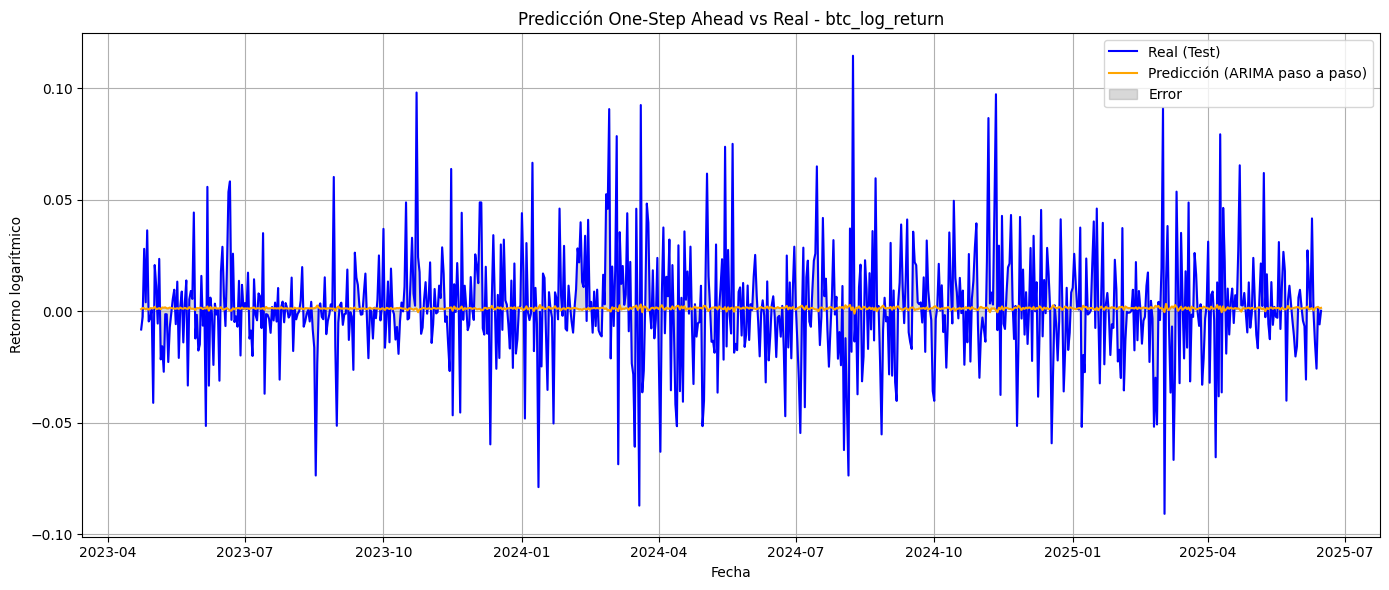

In [108]:
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"📊 MAE:  {mae:.6f}")
print(f"📊 RMSE: {rmse:.6f}")

# 4. Graficar predicción vs real
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label='Real (Test)', color='blue')
plt.plot(test.index, predictions, label='Predicción (ARIMA paso a paso)', color='orange')
plt.fill_between(test.index, test, predictions, color='gray', alpha=0.3, label='Error')
plt.title('Predicción One-Step Ahead vs Real - btc_log_return')
plt.xlabel('Fecha')
plt.ylabel('Retorno logarítmico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Vemos que el modelo logra predecir con un error relativamente bajo. Un retorno logarítmico diario típico en cripto suele oscilar entre -0.05 y 0.05 en días comunes. Un RMSE de ~0.027 es razonable.



In [109]:
import numpy as np

errors = np.abs(test.values - np.array(predictions))

# Umbral relevante (por ejemplo, 0.05 de retorno logarítmico ≈ 5%)
threshold = 0.05
n_above_threshold = np.sum(errors > threshold)
pct_above_threshold = n_above_threshold / len(errors) * 100

print(f"Número de errores > {threshold:.2f}: {n_above_threshold}")
print(f"Eso representa el {pct_above_threshold:.2f}% del total")


Número de errores > 0.05: 48
Eso representa el 6.11% del total


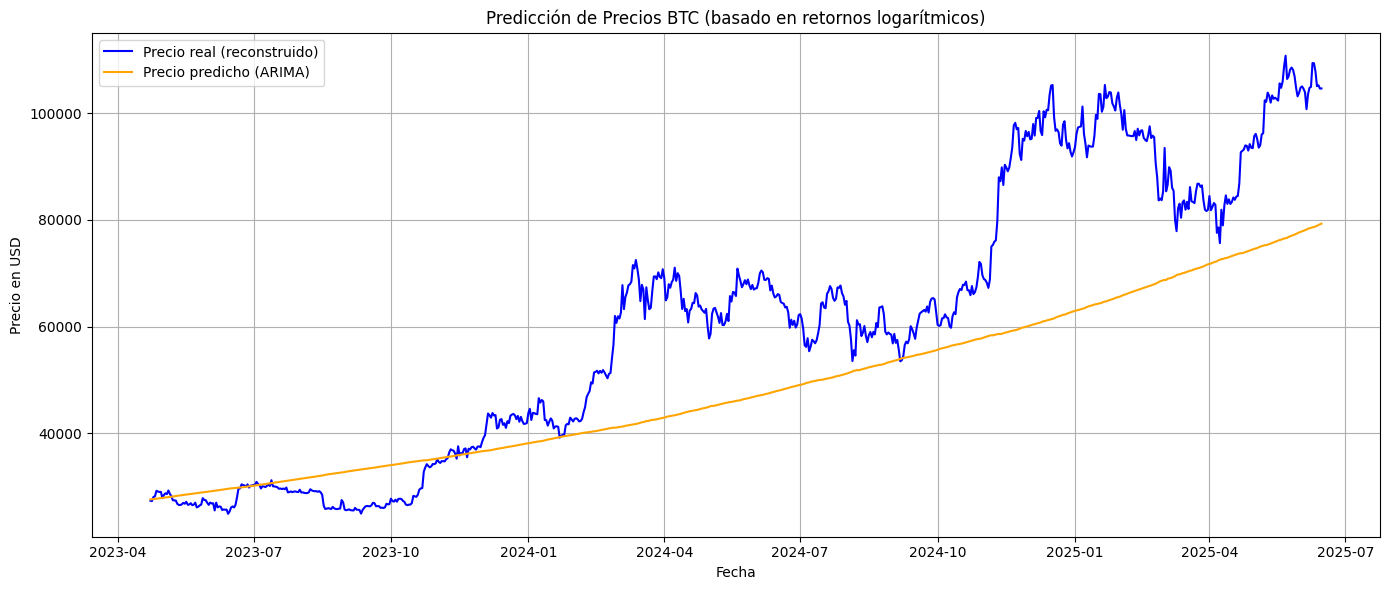

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Precio real inicial del período de test
P0 = df.loc[test.index[0], 'btc_close']

# 2. Acumular retornos log predichos y reales
log_returns_pred = pd.Series(predictions, index=test.index)
log_returns_real = test

# 3. Reconstruir precios predichos y reales
price_pred = P0 * np.exp(log_returns_pred.cumsum())
price_real = P0 * np.exp(log_returns_real.cumsum())

# 4. Graficar comparación
plt.figure(figsize=(14, 6))
plt.plot(price_real.index, price_real, label='Precio real (reconstruido)', color='blue')
plt.plot(price_pred.index, price_pred, label='Precio predicho (ARIMA)', color='orange')
plt.title('Predicción de Precios BTC (basado en retornos logarítmicos)')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
